<h1>Automated Flood Detection based on Satellite Images</h1>
<br>
This project focuses on flood detection using only the SEN2 data from the SEN12-FLOOD dataset. The goal is to process Sentinel-2 satellite images, specifically four spectral bands: Band2 (blue), Band3 (green), Band4 (red), and Band8 (infrared). These bands are important for distinguishing between land, water, and other surface features. The process involves organizing the data, checking for empty images, and stacking the bands together for further analysis, which will be used for flood detection tasks.
<br>
<hr>
Dataset:<br>
Clément Rambour, Nicolas Audebert, Elise Koeniguer, Bertrand Le Saux, Michel Crucianu, Mihai Datcu. (2020). SEN12-FLOOD : a SAR and Multispectral Dataset for Flood Detection . IEEE Dataport. https://dx.doi.org/10.21227/w6xz-s898

Download (after free registration) - 12,2Gb: https://ieee-dataport.org/open-access/sen12-flood-sar-and-multispectral-dataset-flood-detection


<h2>Import of used packages</h2>

Run the following command to install required packages:
'pip install rasterio opencv-python torch torchvision tifffile tensorflow matplotlib'

In [4]:
import rasterio
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import tifffile as tiff  # TIFF fájlok betöltéséhez és kezeléséhez
import json
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

<h2>Directory and file setup</h2>

This function will check if the selected folder has a non-empty B02 file:

In [5]:
def check_img_content(path):
    
    path = os.path.join(path, 'B02.tif')

    # Load the image in grayscale mode (0)
    image = cv2.imread(path,0)
  
    # Return True if all pixels are zero (empty image), otherwise False
    if (cv2.countNonZero(image) == 0): return  True
    else: return  False

In [6]:
def remove_folders(path):
    # Delete the folder and all its contents
    shutil.rmtree(path)

This function performs a series of file structure modifications, to transform the downloaded data before processing. It will also throw away unused files and the original folders.

In [7]:
def create_dir_structure(flist):
    for folder in flist:
        prefix = folder[:11]    # Extract prefix from folder name
        id = folder[11:]        # Extract id from folder name

        if len(id) > 4: continue # Skip if id length is more than 4, because the id can be at most 4 digits

        for file in os.listdir(folder):

            if file.startswith('S1'): 
                os.remove(os.path.join(prefix + id, file)) # Remove files starting with 'S1'
                continue

            # If the file is a spectral band (B02, B03, B04, B08)
            if file.endswith('B02.tif') or file.endswith('B03.tif') or file.endswith('B04.tif') or file.endswith('B08.tif'):
                date = file[3:13] # Extract date from file name
                newFolder =  os.path.join(prefix,'S2_' + id + '_'+ date) # Create new folder name

                if os.path.isdir(newFolder):
                    shutil.move(os.path.join(folder, file), os.path.join(newFolder, file[14:])) # Move file if folder exists
                    
                else:
                    os.mkdir(newFolder)     # Create folder if it doesn't exist
                    shutil.move(os.path.join(folder, file), os.path.join(newFolder, file[14:]))  # Move file

        remove_folders(folder) # Remove the original folder after moving files


This function will stack the 4 image bands into 1 output file, which will be used for training and testing:

In [8]:
def stack_bands(path):

    band_list = ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']
    try:
        
        # Read metadata from the first band (B02.tif) 
        with rasterio.open(os.path.join(path, band_list[0])) as src0:
            meta = src0.meta # Extract metadata from the first band
        
        # Update metadata to reflect the number of bands (layers) 
        meta.update(count = len(band_list))

       # Create a new stack file and write each band to it
        with rasterio.open(os.path.join(path, 'stack.tif'), 'w', **meta) as dst:
            for id, layer in enumerate(band_list, start=1):
                with rasterio.open(os.path.join(path, layer)) as src1:
                    dst.write_band(id, src1.read(1)) # Write each band to the stack file
    except:
        print("Folder with no Data") # Handle cases where the folder has no valid data 
        remove_folders(path) # Remove the folder if there's an issue
        
        pass # Continue without stopping on error 

Read and store the folder list:

In [9]:
folderList = []

rootdir = os.path.normpath('./SEN12FLOOD')  # Get the absolute path for the root directory
#rootdir = './SEN12FLOOD' 
for file in os.listdir(rootdir):
    d = os.path.join(rootdir, file) # Create the full path for each file/folder
    if os.path.isdir(d):    # Check if it's a folder
        folderList.append(d)     # Add folder to the list
        
# Print the total number of folders found        
print(f"The number of folders are currently = {len(folderList)}")

The number of folders are currently = 335


Based on the original folder list, create the new structure. The function will ignore already transformed folders, running multiple times is safe.

In [10]:
# Call the function to create the directory structure for the initial folder list (can run up to 1-2 min)
create_dir_structure(folderList)

Read and store the updated folder list:

In [11]:
folderList = []
#rootdir = './SEN12FLOOD'
rootdir = os.path.normpath('./SEN12FLOOD')
for file in os.listdir(rootdir):
     if 'S2_' in file:
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            folderList.append(d)
        
print(f"The number of folders are currently = {len(folderList)}")


The number of folders are currently = 2237


Based on the updated folder list, stack the selected bands:

In [12]:
#Iterate through all folders and create a new image with 4 spectral bands:
#Band2 (blue), Band3 (green), Band4 (red), and Band8 (infrared)
#This process can take up to 2-5 minutes to complete

for folder_path in folderList:
    empty = check_img_content(folder_path) # Check if the folder contains empty images (all pixels are zero)
    if empty:
        
        print("The images inside the current folder are empty - zero")
        remove_folders(folder_path) # Remove the folder if images are empty 
    else:
        stack_bands(folder_path) # Stack the spectral bands if images are valid

The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the current folder are empty - zero
The images inside the curren

<h2>JSON Metadata Processing</h2>

Load the JSON content into the 'data' variable:

In [13]:
with open('./SEN12FLOOD/S2list.json', 'r') as file:
    data = json.load(file)

print( data)

{'0063': {'1': {'date': '2019-02-04', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-04'}, 'count': 1, 'folder': '0063', 'geo': {'type': 'Polygon', 'coordinates': [[[28.29722, -15.382762], [28.297507, -15.429039], [28.345216, -15.428755], [28.344918, -15.382479], [28.29722, -15.382762]]]}}, '0200': {'1': {'date': '2019-02-23', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-23'}, '2': {'date': '2019-02-28', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-02-28'}, '3': {'date': '2019-03-10', 'FLOODING': False, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-03-10'}, '4': {'date': '2019-03-25', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-03-25'}, '5': {'date': '2019-04-04', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-04-04'}, '6': {'date': '2019-04-14', 'FLOODING': True, 'FULL-DATA-COVERAGE': True, 'filename': 'S2_2019-04-14'}, '7': {'date': '2019-04-24', 'FLOODING': True, 'F

Iterate through the JSON structure, and write the FLOODING boolean attribute into the 'flooding.txt' file in each corresponfing folder:

In [14]:
for location_id, location_data in data.items():
    for location_date, date_data in location_data.items():
        if location_date == 'geo' or location_date =='count' or location_date =='folder': continue
        folder = os.path.join(rootdir, 'S2_' + location_id + '_' + date_data['date'])
        file = os.path.join(folder, 'flooding.txt')

        if os.path.isdir(folder):
            with open(file, 'w') as f:
                f.write(f"{date_data['FLOODING']}\n")

<h2>Data Augmentation</h2>

Composition of used transformations:

In [15]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),  # random rotation up to 15 degrees
])

Applying the augmentation and creating the new files:

In [16]:
def augment_images_in_directory(input_dir):
    # Iterate through files in the specified directory
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file == 'stack.tif':  # Focus only on 'stack.tif' images
                file_path = os.path.join(root, file)
                
                # Load TIFF image with 4 channels (HxWxC)
                img = tiff.imread(file_path)
                
                # Convert image to tensor and rearrange to (CxHxW format for PyTorch)
                img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()
                
                # Apply augmentation
                img_transformed = train_transform(img_tensor)
                
                # Convert image back to (HxWxC format for numpy)
                img_transformed = img_transformed.permute(1, 2, 0).numpy().astype(np.uint16)
                
                # Save augmented image with new name: 'astack.tif'
                save_path = os.path.join(root, 'astack.tif')
                tiff.imwrite(save_path, img_transformed)

# Main execution
input_directory = './SEN12FLOOD'  # Root directory where the folders are located
augment_images_in_directory(input_directory)

<h2>Data loading</h2>

The getLabel function will return 0 or 1, depending whether the folder on 'path' contains FLOODED images or not:

In [17]:
def getLabel(path):
    filepath = os.path.normpath(os.path.join(path, 'flooding.txt'))
    with open(filepath, 'r') as file:
        data = file.readline().strip()
        if(data =="False"):
            return 0
        else:
            return 1

We can define the train-test split ratio and the shuffle seed here:

In [18]:
train_size = 0.7
shuffle_seed = 42

Shuffle and split the folder list into separate folder lists for training and testing:

In [19]:
folderList = []
rootdir = os.path.normpath('./SEN12FLOOD')
for file in os.listdir(rootdir):
     if 'S2_' in file:
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            folderList.append(d)

size =   len(folderList)
        
print(f"The number of folders are currently = {size}")

shuffledData = random.Random(shuffle_seed).shuffle(folderList)

test_start = round(size * train_size)

train_list = folderList[:test_start]
test_list = folderList[test_start:]

print(f"The number of folders for training are currently = {len(train_list)}")
print(f"The number of folders for testing are currently = {len(test_list)}")

The number of folders are currently = 2039
The number of folders for training are currently = 1427
The number of folders for testing are currently = 612


The load data function create the format necessary for further processing, based on train_list and test_list:

In [20]:
def load_data():

    images_train = []
    labels_train = []
    images_test = []
    labels_test = []


    #Training data
    for folder in train_list:
        
        #Add original image
        imagePath = os.path.join(folder, "stack.tif")
        image = cv2.imread(imagePath)
        images_train.append(image)

        #Add augmented image
        imagePath = os.path.join(folder, "astack.tif")
        image = cv2.imread(imagePath)
        images_train.append(image)

        #Add the same label twice (possible point to be optimized?)
        label = getLabel(folder)
        labels_train.append(label)
        labels_train.append(label)

    #Test data
    for folder in test_list:
        
        #Add original image only
        imagePath = os.path.join(folder, "stack.tif")
        image = cv2.imread(imagePath)
        images_test.append(image)

        #Add label
        label = getLabel(folder)
        labels_test.append(label)

    #Convert to np arrays
    images_train = np.array(images_train, dtype = 'float32')
    labels_train = np.array(labels_train, dtype = 'int32')
    images_test = np.array(images_test, dtype = 'float32')
    labels_test = np.array(labels_test, dtype = 'int32')

    return images_train, images_test, labels_train, labels_test
    

Load the data into X and y train and test arrays:

In [21]:
X_train, X_test, y_train, y_test = load_data()

Notice that X_train has double the rows as the training folders, as both the original and the augmented image is added.
Meanwhile the test data has the same number of rows as the test folder count:

In [22]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(2854, 512, 512, 3)
(2854,)
(612, 512, 512, 3)
(612,)


<h2>Data Analysis</h2>

This function prints information on the distribution of FLOODED and CLEAR data:

In [23]:
def analyseLabels(labels):
    (unique, counts) = np.unique(labels, return_counts=True)

    print(f"FLOODED - images containing flooded areas in this dataset: {counts[1]}\n")
    print(f"CLEAR - images containing clear areas in this dataset: {counts[0]}\n")
    percentage = round(counts[1] / (counts[0] + counts[1]) * 100, 3)
    print(f"Percentage of FLOODED areas: " + str(percentage) + "%")

Training data analysis:

In [24]:
analyseLabels(y_train)

FLOODED - images containing flooded areas in this dataset: 668

CLEAR - images containing clear areas in this dataset: 2186

Percentage of FLOODED areas: 23.406%


Test data analysis:

In [25]:
analyseLabels(y_test)

FLOODED - images containing flooded areas in this dataset: 135

CLEAR - images containing clear areas in this dataset: 477

Percentage of FLOODED areas: 22.059%


<h2>Model Definition</h2>

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (512, 512, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])

C:\Users\szlad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

<h2>Training</h2>

Hyperparameters:

In [28]:
batch_size = 28 

epochs = 10 

validation_split = 1 - train_size

Running the training:

In [29]:
history = model.fit( X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = validation_split)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.6888 - loss: 21.2677 - val_accuracy: 0.7596 - val_loss: 0.5666
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.7843 - loss: 0.5245 - val_accuracy: 0.7678 - val_loss: 0.5356
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.8659 - loss: 0.3213 - val_accuracy: 0.7830 - val_loss: 0.5087
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.9346 - loss: 0.1550 - val_accuracy: 0.7760 - val_loss: 0.9051
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.9651 - loss: 0.1031 - val_accuracy: 0.7655 - val_loss: 0.5727
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.9800 - loss: 0.0659 - val_accuracy: 0.7876 - val_loss: 0.8781
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 229s 3s/step - accuracy: 0.9865 - loss: 0.0417 - val_accuracy: 0.7806 - val_loss: 1.0863
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.9852 - loss: 0.0574 - val_accuracy: 0.7795 - 

<h2>Evaluation</h2>

In [30]:
def plot_accuracy_loss(history):

    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

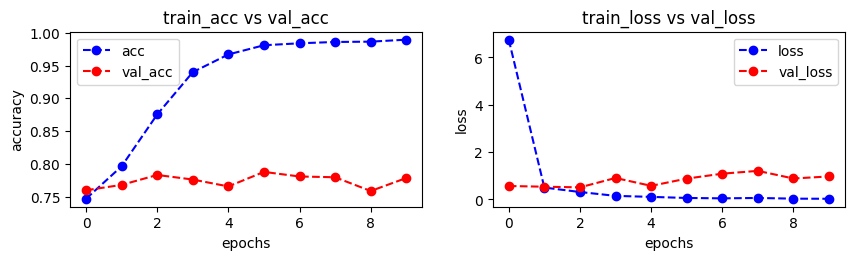

In [31]:
plot_accuracy_loss(history)